In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin


## QUESTION 19: 
In a brief paragraph discuss: If the VGG network is trained on a dataset with
perhaps totally different classes as targets, why would one expect the features derived from such a network to have discriminative power for a custom dataset?

Pretrained networks such as VGG are often trained on vast amounts of data, often much larger in size than the training data we have available in the custom dataset for our particular task. The depth of these pretrained models mean that the earlier layers of the convolutional network tends to 'learn' more basic features such as edges or blobs (a fact verified by looking at the representations extracted from these lower layers). The detection of these features are essential to nearly all visual recognition tasks. Thus we can take the representations obtained from a pretrained model and then 'fine-tune' it on our custom dataset by merely creating a simple classification head for our given task, often by creating a far more simple network with just a few hidden states

## QUESTION 20: 
In a brief paragraph explain how the helper code base is performing feature
extraction.

Feature extraction in the helper code case is performed using the FeatureExtractor class, which inherits from the nn.Module class (and thus the \_\_call__ attribute is overriden with forward). In this class, a pretrained vgg network is loaded from torch.hub, and the internal layers of the vgg network are unrolled and packed into a new nn.Sequential layer, followed by avg pooling and flattening, preserving the original structure of VGG-16. However, as the original VGG was trained on the ImageNet task that consisted of a 1000 class image classification problem, it is not necessary for us to retain its classification head and thus we discard all but the first of the fully connected (FC) layers that follow the Convolutional layers.The 4096 dim vector from the first FC layer is treated as our extracted feature vector for subsequent classification tasks.

## QUESTION 21: 
How many pixels are there in the original images? How many features does
the VGG network extract per image; i.e what is the dimension of each feature vector for an image
sample?

 Pixels in the original images: 224x224 = 50176
 
 Features VGG network extracts per image = 4096

## Flowers Dataset and VGG Features

In [ ]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out) 
            return out 

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

100%|██████████| 58/58 [00:42<00:00,  1.36it/s]


In [ ]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]

(3670, 4096) (3670,)


In [ ]:
f_all[0]

array([-1.06958699, -3.62220883, -3.03961301, ..., -7.70226765,
        0.41355097,  0.38116479])

## QUESTION 22: 
Are the extracted features dense or sparse? (Compare with sparse TF-IDF
features in text.)

No, the extracted features are not sparse. Compared to a TF-IDF matrix they are not similar to a one hot encoded vector and are instead the activations of a FC layer in the VGG network containing latent information about various structural features seen in the image

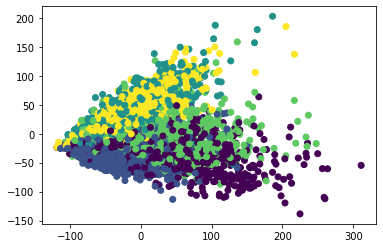

In [ ]:
f_pca = PCA(n_components=2).fit_transform(f_all)
plt.scatter(*f_pca.T, c=y_all)

## MLP Classifier

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), 
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()
    
    
    def forward(self, X):
        return self.model(X)
    
    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()
        
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:

                optimizer.zero_grad()
                outputs = self.model(X_)
      
                loss = criterion(outputs, y_)
      
                loss.backward()
      
                optimizer.step()
        return self
    
    def eval(self, X_test, y_test):
        X_test = torch.tensor(X_test, dtype=torch.float32, device='cuda')
        y_test = torch.tensor(y_test, dtype=torch.int64, device='cuda')
        with torch.no_grad():
          self.model.eval()

          y_logits = self.model(X_test)

          y_pred = torch.argmax(y_logits, dim=-1)
      
          acc = (y_pred == y_test).sum()/len(y_test)

          return acc


## Autoencoder

In [ ]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None
        
    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))
    
    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))
    
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self     
        
    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

100%|██████████| 100/100 [00:24<00:00,  4.17it/s]


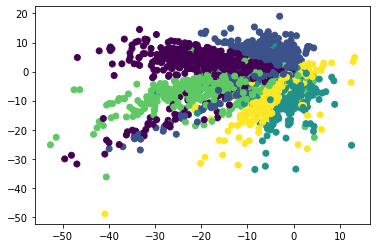

In [ ]:
X_em =Autoencoder(2).fit_transform(f_all)
plt.scatter(*X_em.T, c=y_all)

## QUESTION 23: 
In order to inspect the high-dimensional features, t-SNE is a popular off-the-shelf choice for visualizing Vision features. Map the features you have extracted onto 2 dimensions with t-SNE. Then plot the mapped feature vectors along x and y axes. Color-code the data points with ground-truth labels. Describe your observation.

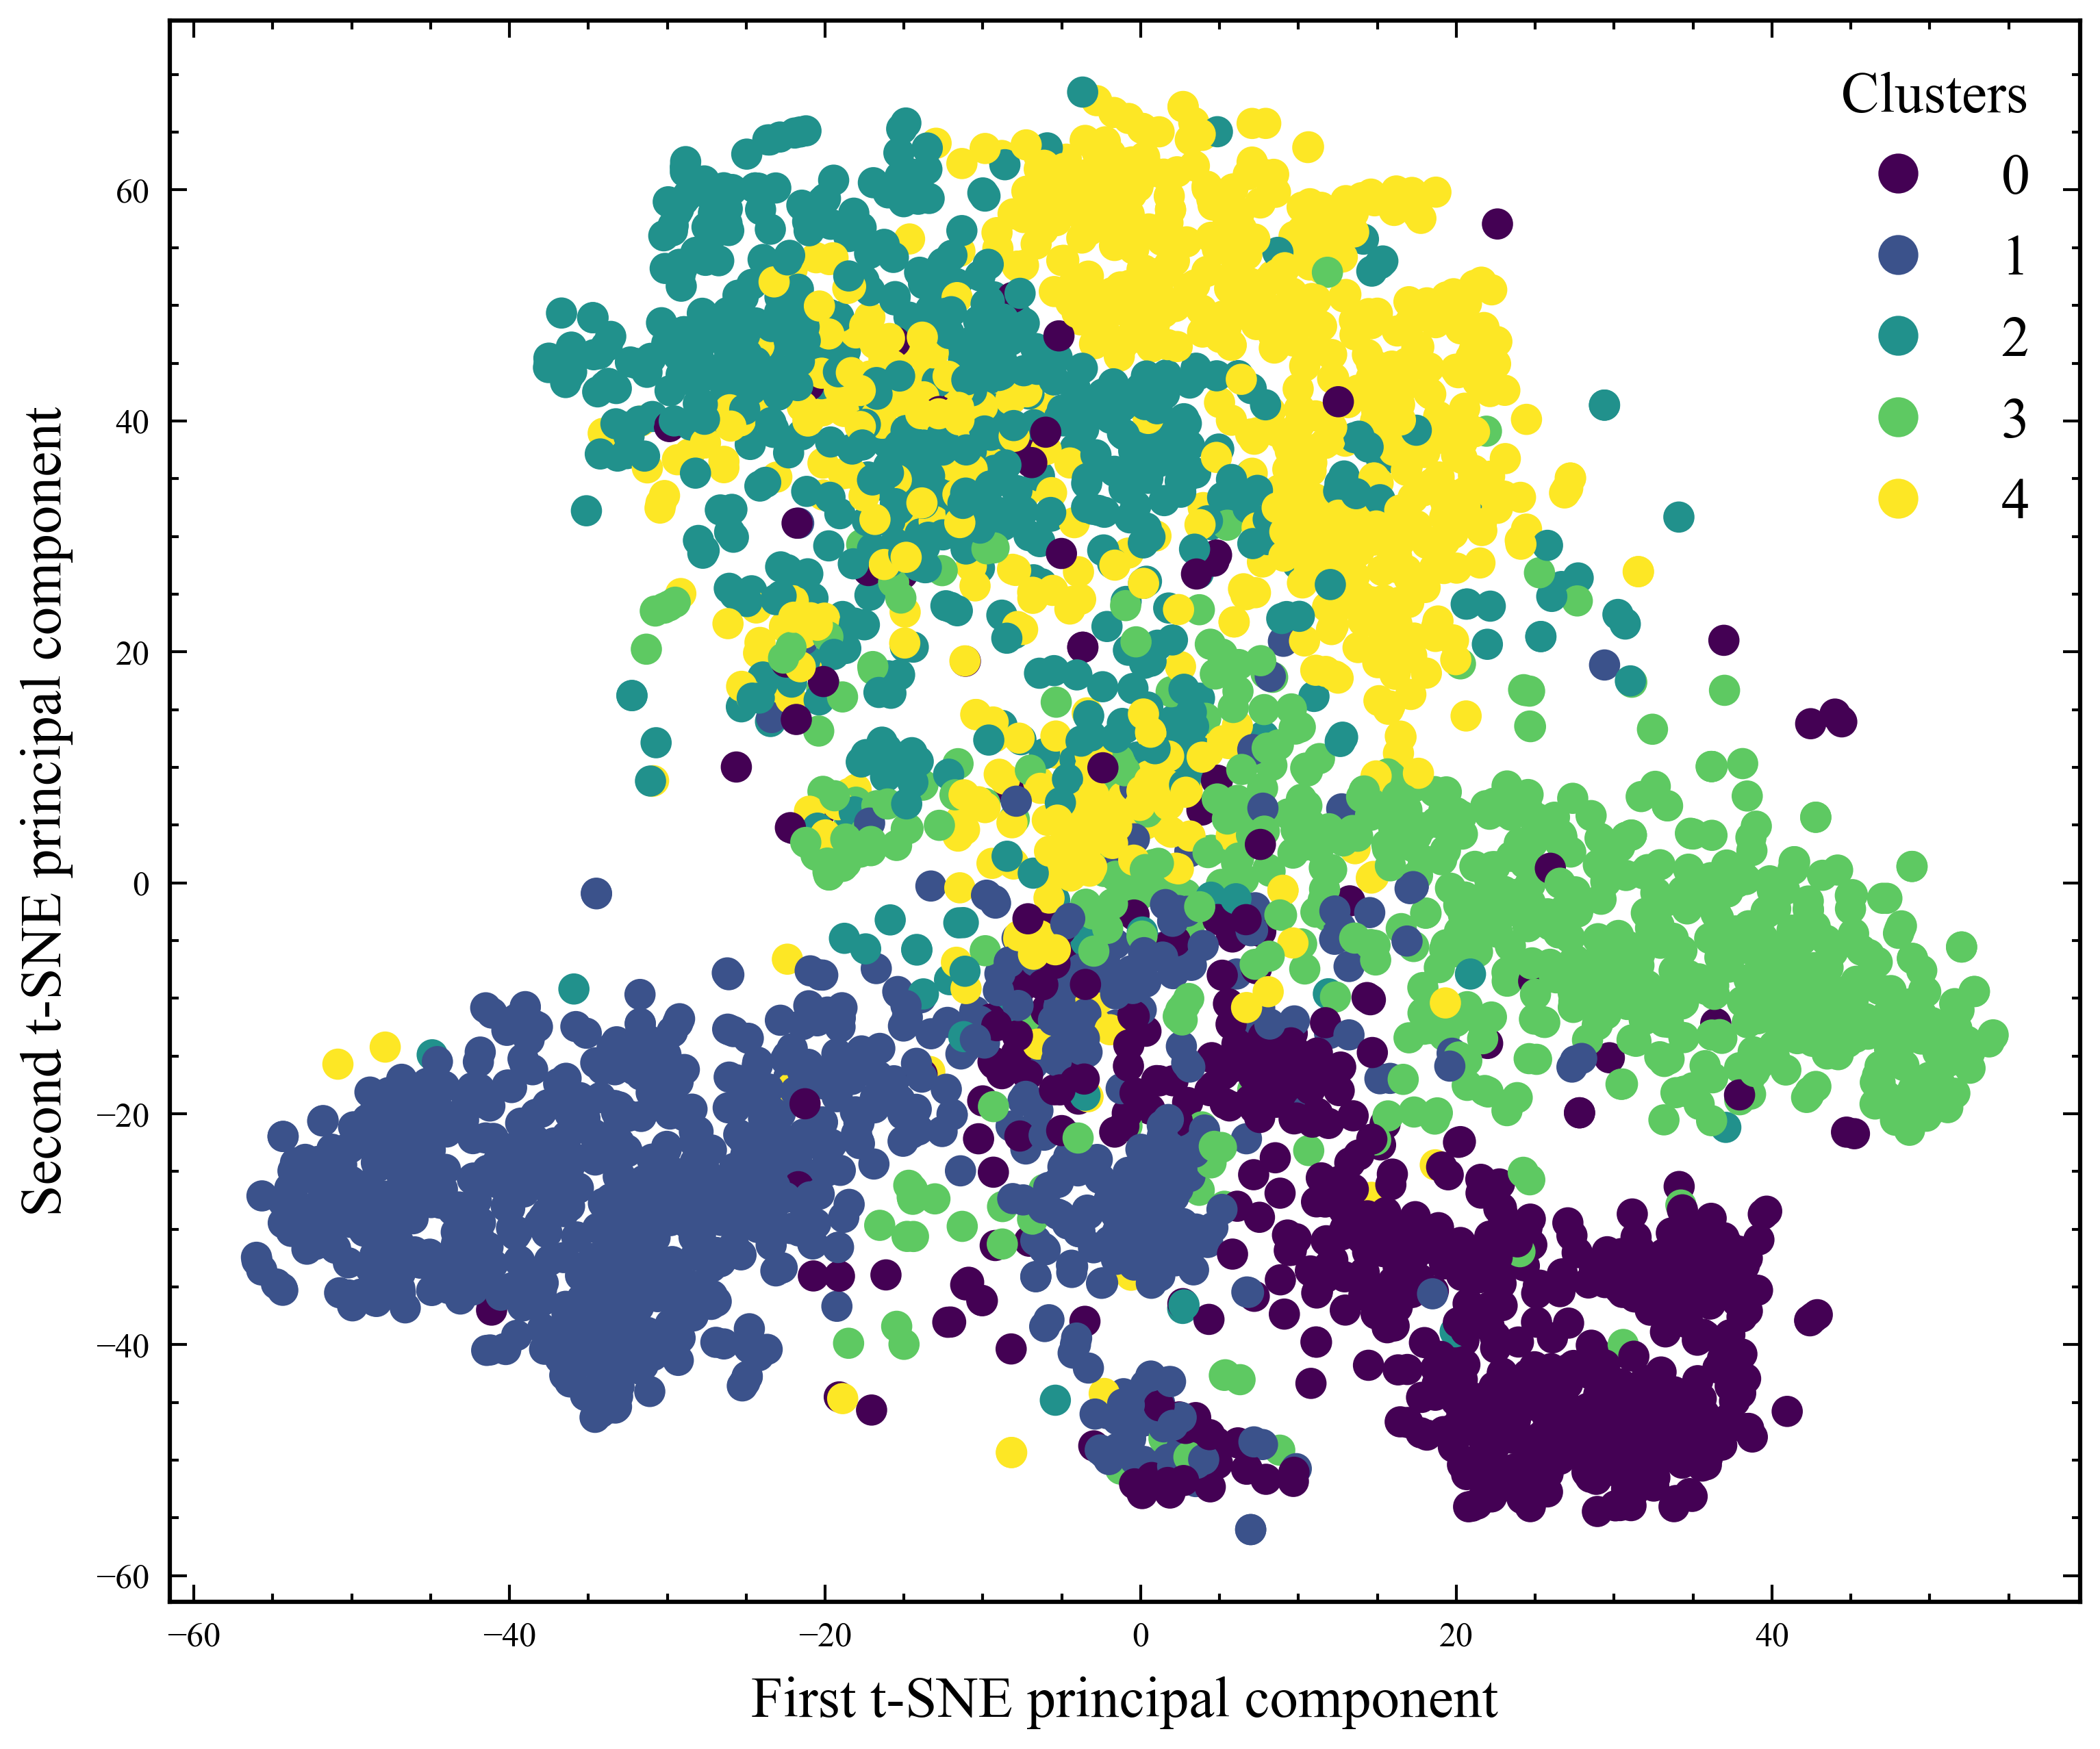

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE()
f_tsne = tsne.fit_transform(f_all)

plt.figure(figsize=(6,5), dpi=300)
scatter = plt.scatter(*f_tsne.T, c=y_all, s=20)
plt.xlabel("First t-SNE principal component")
plt.ylabel("Second t-SNE principal component")
plt.xticks(size=6)    
plt.yticks(size=6)
plt.legend(*scatter.legend_elements(), loc="upper right", title="Clusters") 
plt.savefig("Q23.pdf", dpi=500, bbox_inches='tight')
plt.show()

We observe that when we color code the data points with ground truth labels that similar points tend to form distinct clusters in the 2D plot. This indicates that the extracted features from the VGG net do contain discriminative power, and thus it would be possible to build a classification network using these features to accurately predict the correct category using these features

## QUESTION 24: 
Report the best result (in terms of rand score) within the table below.
For HDBSCAN, introduce a conservative parameter grid over min cluster size and min samples.

In [ ]:
%pip install umap-learn
%pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=62704df02163d23ed024850fe58d6dc7014bd4d5b6d3a56b1aa08988171643e1
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=839b4d70db840f96fc8f0dde13eb350dca441fb541e376d73ccc5467a589f6c3
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/pu

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import umap
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans,  AgglomerativeClustering, DBSCAN
import hdbscan
from sklearn.metrics import rand_score

import warnings
warnings.filterwarnings('ignore')


In [ ]:
reduce_dim_dict =  {'None':None, 
                'TruncatedSVD':TruncatedSVD(n_iter=7, random_state=0,n_components=50), 
                'UMAP':umap.UMAP(n_components=50, metric='cosine'),
                'Autoencoder':Autoencoder(50)}
reduce_dim =  ['None', 
                'TruncatedSVD', 
                'UMAP',
                'Autoencoder'] 
cluster_dict = {'KMeans': KMeans(n_clusters=5, random_state=0, max_iter=4000, n_init = 60),
        'AgglomerativeClustering': AgglomerativeClustering(n_clusters=5),
        'HDBSCAN': hdbscan.HDBSCAN()}
cluster = ['KMeans',
        'AgglomerativeClustering',
        'HDBSCAN']
  
score_list = []

for r in reduce_dim:

  if reduce_dim_dict[r] is None:
    f_red = f_all
  else:
    f_red = reduce_dim_dict[r].fit_transform(f_all)

  for c in cluster:

    if c != 'HDBSCAN':

      y_pred = cluster_dict[c].fit_predict(f_red)

      ari = rand_score(y_pred, y_all)

      print(r," ",c," ",ari)

      score_list.append([r,c,None, None, ari])
    
    else:

      min_cluster_size_list = [10, 20,50,100,200,350,500,750,1000]
      # min_cluster_size_list = [10,20,30,40,50]

      for mc in min_cluster_size_list:

        min_sample_list = [50, 100, 200,500,750,1000,1500]
        # min_sample_list = [10,20,30,40,50]

        for ms in min_sample_list:

          y_pred = hdbscan.HDBSCAN(min_cluster_size = mc, min_samples=ms).fit_predict(f_red)

          ari = rand_score(y_pred, y_all)

          print(r," ",c," ",mc," ", ms, " ", ari)

          score_list.append([r,c,mc, ms, ari])








None   KMeans   0.7036319468735402
None   AgglomerativeClustering   0.6862000871875192
None   HDBSCAN   10   50   0.20358404572368982
None   HDBSCAN   10   100   0.20358404572368982
None   HDBSCAN   10   200   0.20358404572368982
None   HDBSCAN   10   500   0.20358404572368982
None   HDBSCAN   10   750   0.20358404572368982
None   HDBSCAN   10   1000   0.20358404572368982
None   HDBSCAN   10   1500   0.20358404572368982
None   HDBSCAN   20   50   0.20358404572368982
None   HDBSCAN   20   100   0.20358404572368982
None   HDBSCAN   20   200   0.20358404572368982
None   HDBSCAN   20   500   0.20358404572368982
None   HDBSCAN   20   750   0.20358404572368982
None   HDBSCAN   20   1000   0.20358404572368982
None   HDBSCAN   20   1500   0.20358404572368982
None   HDBSCAN   50   50   0.20358404572368982
None   HDBSCAN   50   100   0.20358404572368982
None   HDBSCAN   50   200   0.20358404572368982
None   HDBSCAN   50   500   0.20358404572368982
None   HDBSCAN   50   750   0.20358404572368982


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


Autoencoder   KMeans   0.7100627319399668
Autoencoder   AgglomerativeClustering   0.7637129109565897
Autoencoder   HDBSCAN   10   50   0.20358404572368982
Autoencoder   HDBSCAN   10   100   0.20358404572368982
Autoencoder   HDBSCAN   10   200   0.20358404572368982
Autoencoder   HDBSCAN   10   500   0.20358404572368982
Autoencoder   HDBSCAN   10   750   0.20358404572368982
Autoencoder   HDBSCAN   10   1000   0.20358404572368982
Autoencoder   HDBSCAN   10   1500   0.20358404572368982
Autoencoder   HDBSCAN   20   50   0.20358404572368982
Autoencoder   HDBSCAN   20   100   0.20358404572368982
Autoencoder   HDBSCAN   20   200   0.20358404572368982
Autoencoder   HDBSCAN   20   500   0.20358404572368982
Autoencoder   HDBSCAN   20   750   0.20358404572368982
Autoencoder   HDBSCAN   20   1000   0.20358404572368982
Autoencoder   HDBSCAN   20   1500   0.20358404572368982
Autoencoder   HDBSCAN   50   50   0.20358404572368982
Autoencoder   HDBSCAN   50   100   0.20358404572368982
Autoencoder   HDBS

In [ ]:
import pandas as pd

results = pd.DataFrame(score_list)
results.columns = ['reduce_dim', 'cluster','min_cluster_size','min_samples','Rand Score']

In [ ]:
results.sort_values(by='Rand Score', inplace=True, ascending = False)
results

,reduce_dim,cluster,min_cluster_size,min_samples,Rand Score
130,UMAP,KMeans,NaN,NaN,0.821825
131,UMAP,AgglomerativeClustering,NaN,NaN,0.812721
196,Autoencoder,AgglomerativeClustering,NaN,NaN,0.763713
66,TruncatedSVD,AgglomerativeClustering,NaN,NaN,0.753370
195,Autoencoder,KMeans,NaN,NaN,0.710063
...,...,...,...,...,...
95,TruncatedSVD,HDBSCAN,200.0,50.0,0.203584
96,TruncatedSVD,HDBSCAN,200.0,100.0,0.203584
97,TruncatedSVD,HDBSCAN,200.0,200.0,0.203584
98,TruncatedSVD,HDBSCAN,200.0,500.0,0.203584


In [ ]:
#Best 5 Pipelines

results.head(5)

,reduce_dim,cluster,min_cluster_size,min_samples,Rand Score
130,UMAP,KMeans,NaN,NaN,0.821825
131,UMAP,AgglomerativeClustering,NaN,NaN,0.812721
196,Autoencoder,AgglomerativeClustering,NaN,NaN,0.763713
66,TruncatedSVD,AgglomerativeClustering,NaN,NaN,0.753370
195,Autoencoder,KMeans,NaN,NaN,0.710063


We observe that the best combination of Dimensionality reduction + Clustering is performed by:

Dimensionality Reduction - UMAP(n_components = 50)

Clustering - KMeans(k = 5)

## QUESTION 25: 
Report the test accuracy of the MLP classifier on the original VGG features.

Report the same when using the reduced-dimension features (you have freedom in choosing the dimensionality reduction algorithm and its parameters). 

Does the performance of the model suffer with the reduced-dimension representations? 

Is it significant? 

Does the success in classification make sense in the context of the clustering results obtained for the same features in Question 24.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(f_all, y_all, test_size=0.2, random_state=42)

In [ ]:
mlp = MLP(num_features = X_train.shape[1])

In [ ]:
mlp.train(X_train,y_train)

100%|██████████| 100/100 [00:12<00:00,  7.81it/s]


MLP(
  (model): Sequential(
    (0): Linear(in_features=4096, out_features=1280, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1280, out_features=640, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=640, out_features=5, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

In [ ]:
acc = mlp.eval(X_test,y_test)
print(acc)

tensor(0.9101, device='cuda:0')


In [ ]:
f_red = Autoencoder(50).fit_transform(f_all)

100%|██████████| 100/100 [00:24<00:00,  4.16it/s]


In [ ]:
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(f_red, y_all, test_size=0.2, random_state=42)

In [ ]:
mlp_red = MLP(num_features = X_train_red.shape[1])

In [ ]:
mlp_red.train(X_train_red,y_train_red)

100%|██████████| 100/100 [00:07<00:00, 12.59it/s]


MLP(
  (model): Sequential(
    (0): Linear(in_features=50, out_features=1280, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1280, out_features=640, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=640, out_features=5, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

In [ ]:
acc = mlp_red.eval(X_test_red,y_test_red)
print(acc)

tensor(0.8774, device='cuda:0')


Test accuracy of the MLP classifier on the original VGG features: 91.01%

Test accuracy of the MLP classifier on the reduced dimension features: 87.74%

Does the performance of the model suffer with the reduced-dimension representations?: Yes, a 3.6% relative decline in accuracy is observed when using the reduced feature set as compared to using the full set of features

Is it significant? 

Does the success in classification make sense in the context of the clustering results?:
As we saw from the clustering of the dataset in the prior question, the extracted features from the VGG net tend to cluster together for the different classes. Thus it stands to reason that a relatively simple network would be able to achieve decent success in classifying the different underlying classes present in this dataset